# Mini-project n°2 – Conditional VAEs

Voici la bibliographie que nous avons utilisé : 
- https://towardsdatascience.com/conditional-variational-autoencoders-for-text-to-image-generation-1996da9cefcb/
- https://creatis-myriad.github.io/tutorials/2022-09-12-tutorial-cvae.html#introduction


## MNIST data-set and librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchvision.transforms.functional as functional
import torch.nn as nn
from torchvision.datasets import FashionMNIST 
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### On télécharge le dataset MNIST

In [2]:
transform = transforms.Compose([transforms.ToTensor(),])

train_dataset = FashionMNIST(root=".",train=True,download=True,transform=transform)
test_dataset = FashionMNIST(root=".",train=False,download=True,transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=False)

print("taille du data_set d'entrainement:",len(train_dataset))
print("taille du data_set de test:",len(test_dataset))

taille du data_set d'entrainement: 60000
taille du data_set de test: 10000


On visualise un exemple de chaque classe

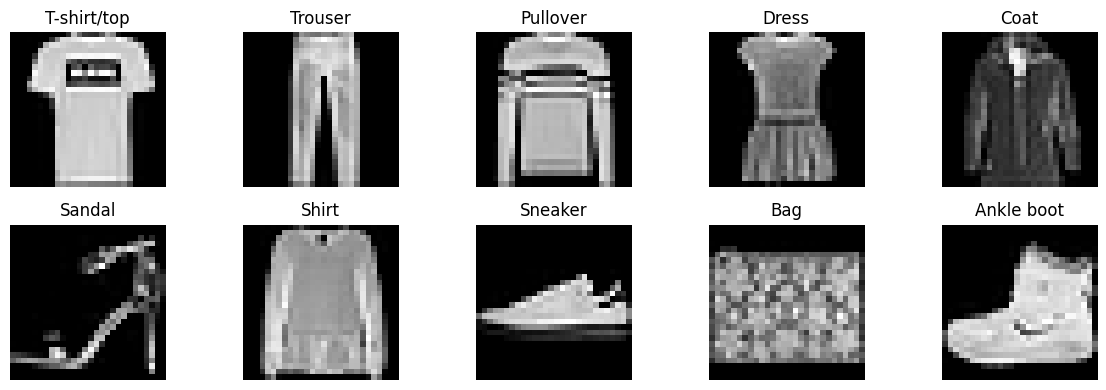

In [3]:
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat","Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"] # Les 10 classes de Fashion-MNIST
label_size=10
examples = {}

for img, label in train_dataset:
    if label not in examples:
        examples[label] = img
    if len(examples) == 10:
        break

# Affichage
plt.figure(figsize=(12, 4))
for label, img in examples.items():
    plt.subplot(2, 5, label + 1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(classes[label])
    plt.axis("off")

plt.tight_layout()
plt.show()

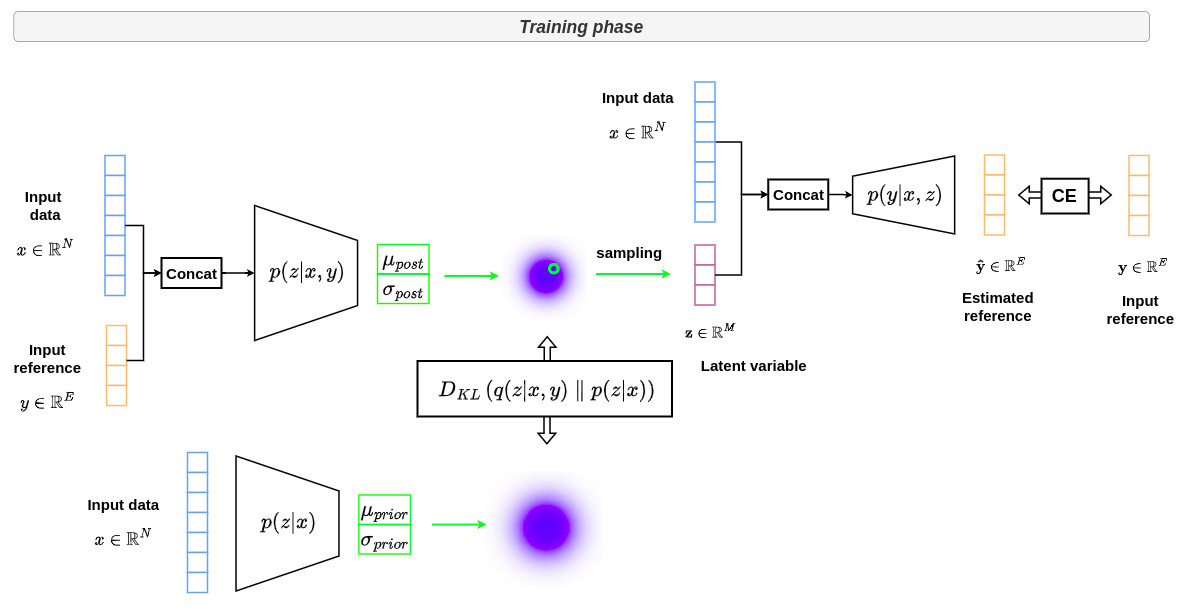

In [ ]:
class cVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(cVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = label_size                                         # On a besoin de l'info du nombre de label

        self.embedding = nn.Embedding(self.num_classes, self.num_classes)
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1+label_size, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),   # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim) 
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim) 
        self.fc_decode = nn.Linear(latent_dim + label_size, 128 * 4 * 4) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )
    
    def encode(self, x, y):
        y_one_hot = F.one_hot(y, num_classes=self.num_classes).float()
        y_img = y_one_hot.unsqueeze(2).unsqueeze(3)      # (batch, 10, 1, 1)
        y_img = y_img.expand(-1, -1, 28, 28)             # (batch, 10, 28, 28)

        x_cond = torch.cat([x, y_img], dim=1)            # (batch, 1+10, 28, 28)

        h = self.encoder(x_cond)                         # passes through conv layers
        h = h.view(-1, 128 * 4 * 4)

        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, y):
        y_one_hot = F.one_hot(y, num_classes=self.num_classes).float()        # (batch, 10)
        z_cond = torch.cat([z, y_one_hot], dim=1)  # (batch, latent_dim + label_size)

        x = self.fc_decode(z_cond)
        x = x.view(-1, 128, 4, 4)
        return self.decoder(x)

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.sample(mu, logvar)
        return self.decode(z, y), mu, logvar


In [5]:
def loss_function(recon_x, x, mu, logvar, beta):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

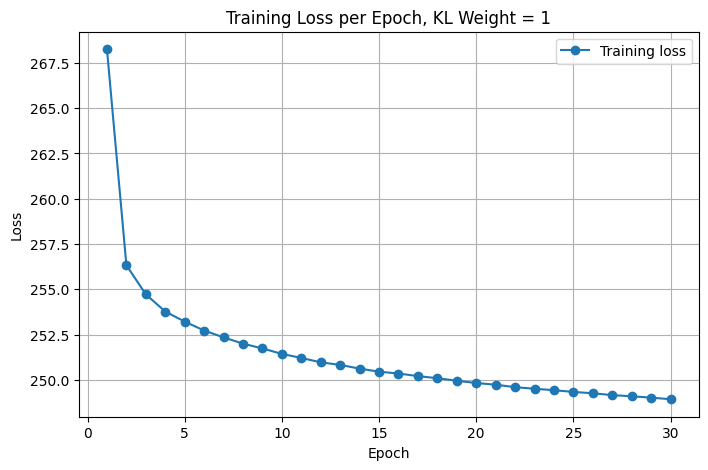

In [ ]:
# Hyperparameters
batch_size = 128
latent_dim = 2
learning_rate = 1e-3
epochs = 30
beta = 1


# Initialize the VAE model and the Adam optimizer
def Train(beta): # On passe beta en paramètre pour plus tard (quand on regarde son influence sur l'espace latent)
    cvae = cVAE(latent_dim=latent_dim)
    cvae.to(device)
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

    losses = []

    # Train the model for the given number of epochs
    # At the end of each epoch, print the training loss
    for epoch in range(1, epochs + 1):
        cvae.train()
        running_loss = 0.0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            recon_batch, mu, logvar = cvae(data, labels)
            loss,_,_ = loss_function(recon_batch, data, mu, logvar,beta)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader.dataset)
        losses.append(epoch_loss)
        #print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')


    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), losses, marker='o', label='Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss per Epoch, KL Weight = {beta}')
    plt.grid(True)
    plt.legend()
    plt.show()
    return cvae
CVAE_1 = Train(beta)

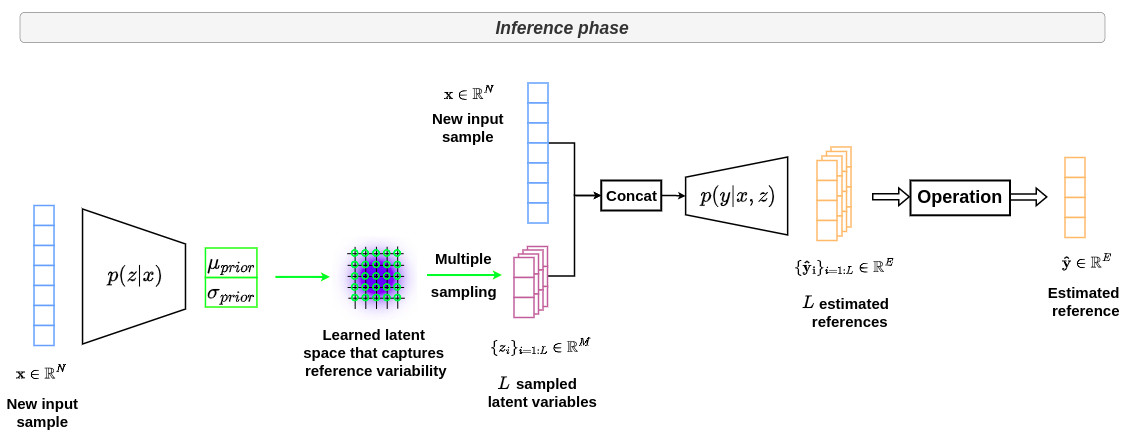

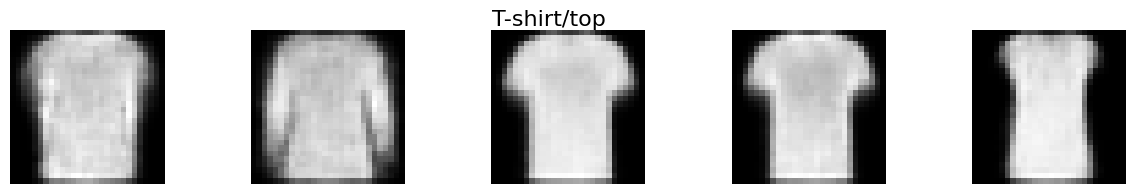

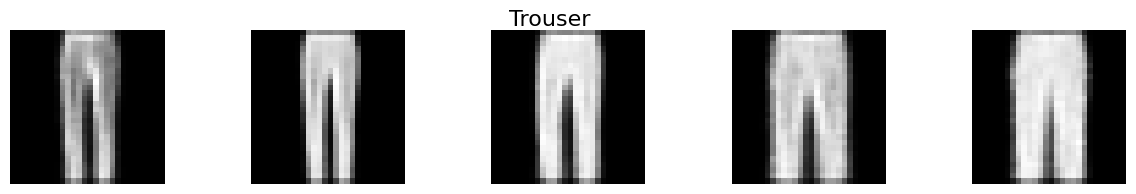

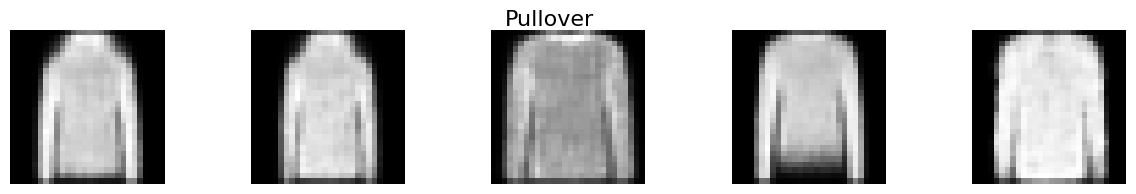

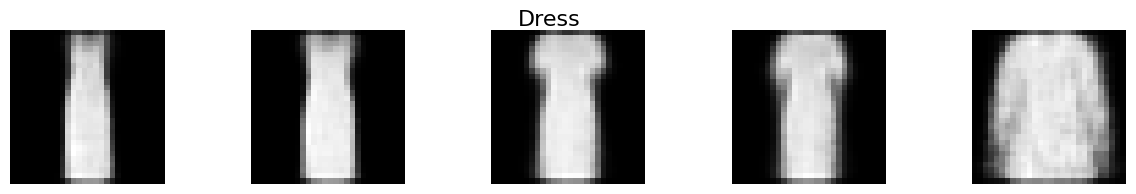

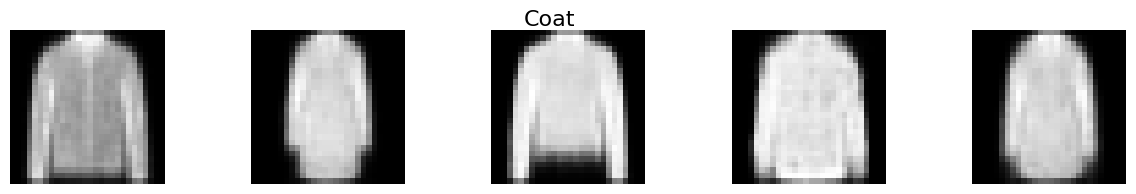

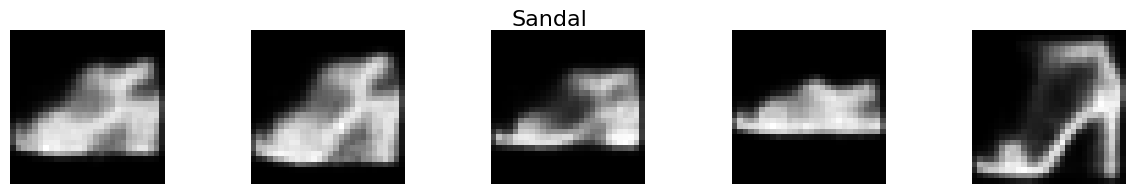

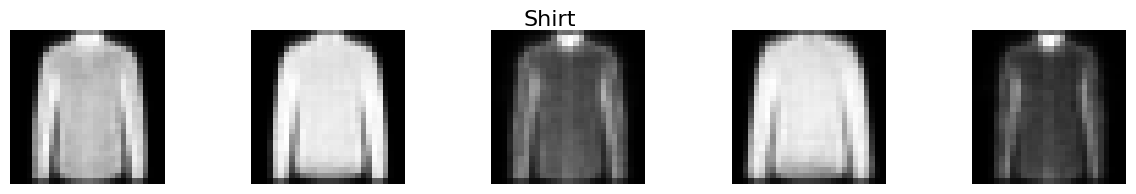

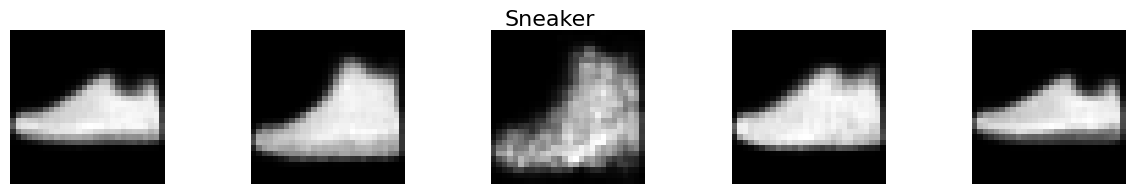

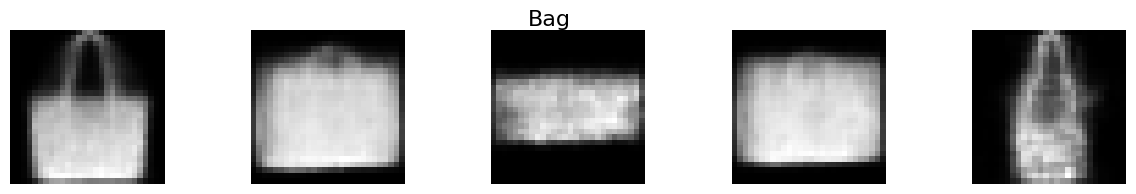

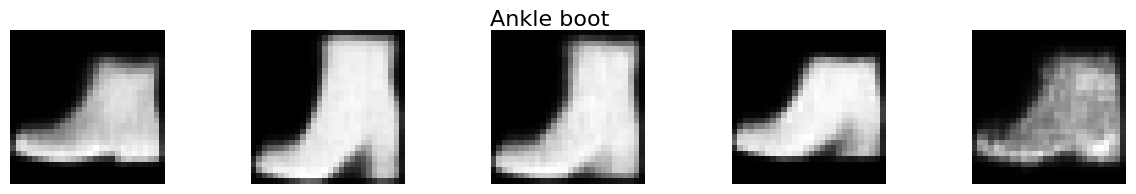

In [7]:
CVAE_1.eval()
n_samples = 5  # nombre d'images par classe
for class_idx, class_name in enumerate(classes):
    plt.figure(figsize=(15, 2))
    plt.suptitle(class_name, fontsize=16)
    
    for i in range(n_samples):
        y = torch.tensor([class_idx], device=device)
        z = torch.randn(1, latent_dim).to(device)
        generated = CVAE_1.decode(z, y).detach().cpu().squeeze()
        
        plt.subplot(1, n_samples, i+1)
        plt.imshow(generated, cmap="gray")
        plt.axis('off')
    
    plt.show()


On va essayer de visualiser l'espace latent :  
The objective of this section is to visualize the latent space and to see how it changes according to which term in the loss function we give more weight to.

In [13]:
def plot_latent_space(model, dataset, device, kl_weight=1.0):
    model.eval()
    with torch.no_grad():
        # On charge tout le dataset en un seul batch (si mémoire le permet)
        test_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
        data, labels = next(iter(test_loader))
        data = data.to(device)
        labels = labels.to(device)
        
        y = nn.functional.one_hot(labels, num_classes=10).float()
        
        # Encode conditioned on labels
        mu, logvar = model.encode(data, labels)
        z = mu.cpu().numpy()  # on prend la moyenne
        labels = labels.cpu().numpy()
        
        # Plot
        plt.figure(figsize=(8,6))
        scatter = plt.scatter(z[:,0], z[:,1], c=labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, ticks=range(10))
        plt.clim(-0.5, 9.5)
        plt.title(f'Latent Space (KL Weight = {kl_weight})')
        plt.xlabel('Z1')
        plt.ylabel('Z2')
        plt.show()



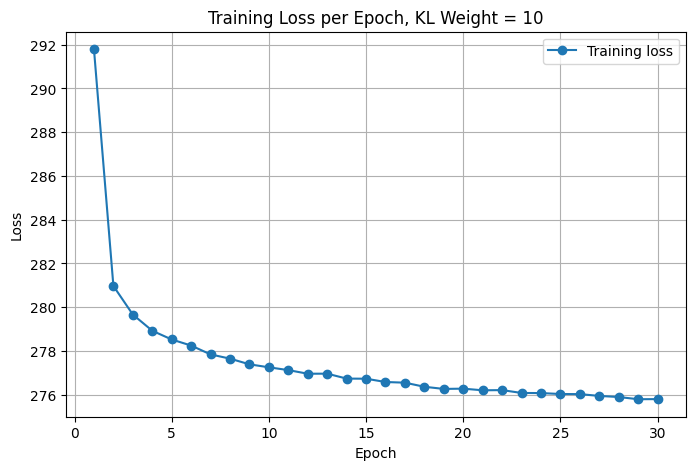

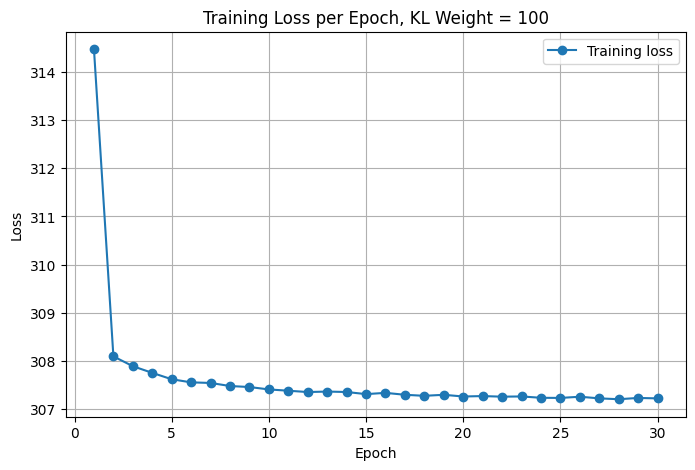

In [9]:
CVAE_10 = Train(10)
CVAE_100 = Train(100)

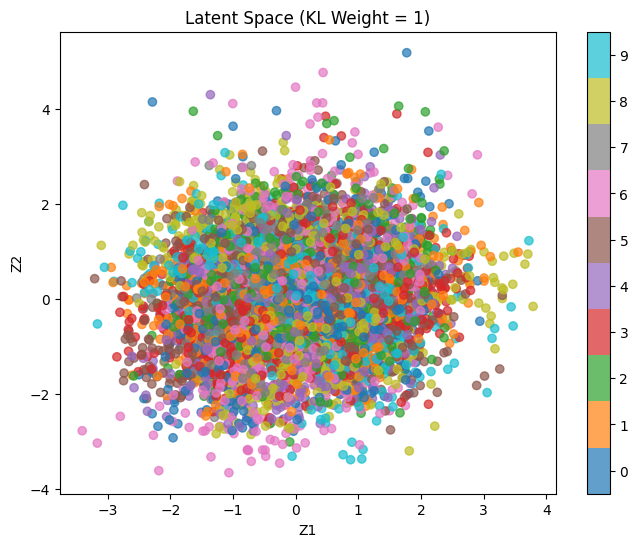

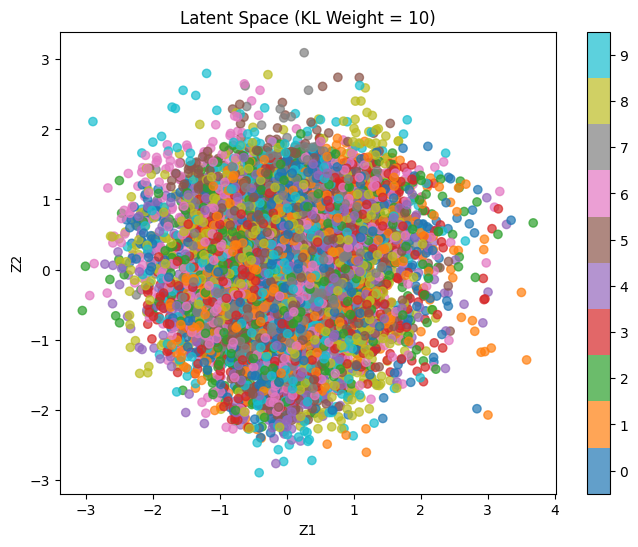

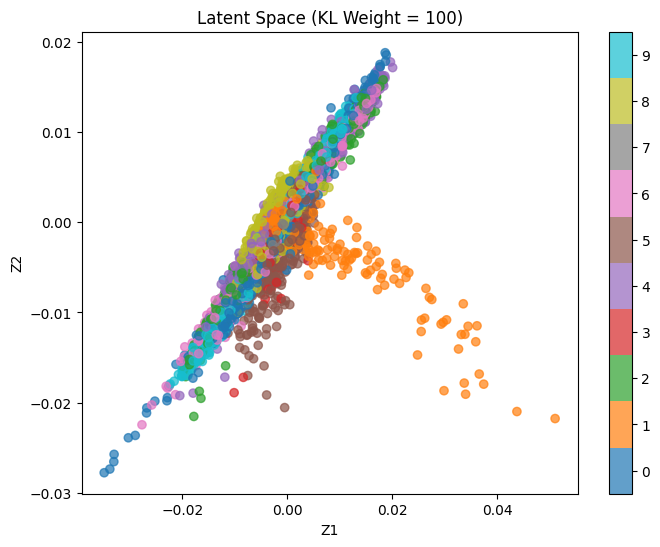

In [14]:
plot_latent_space(CVAE_1, test_dataset, device, kl_weight=1)
plot_latent_space(CVAE_10, test_dataset, device, kl_weight=10)
plot_latent_space(CVAE_100,test_dataset, device, kl_weight=100)

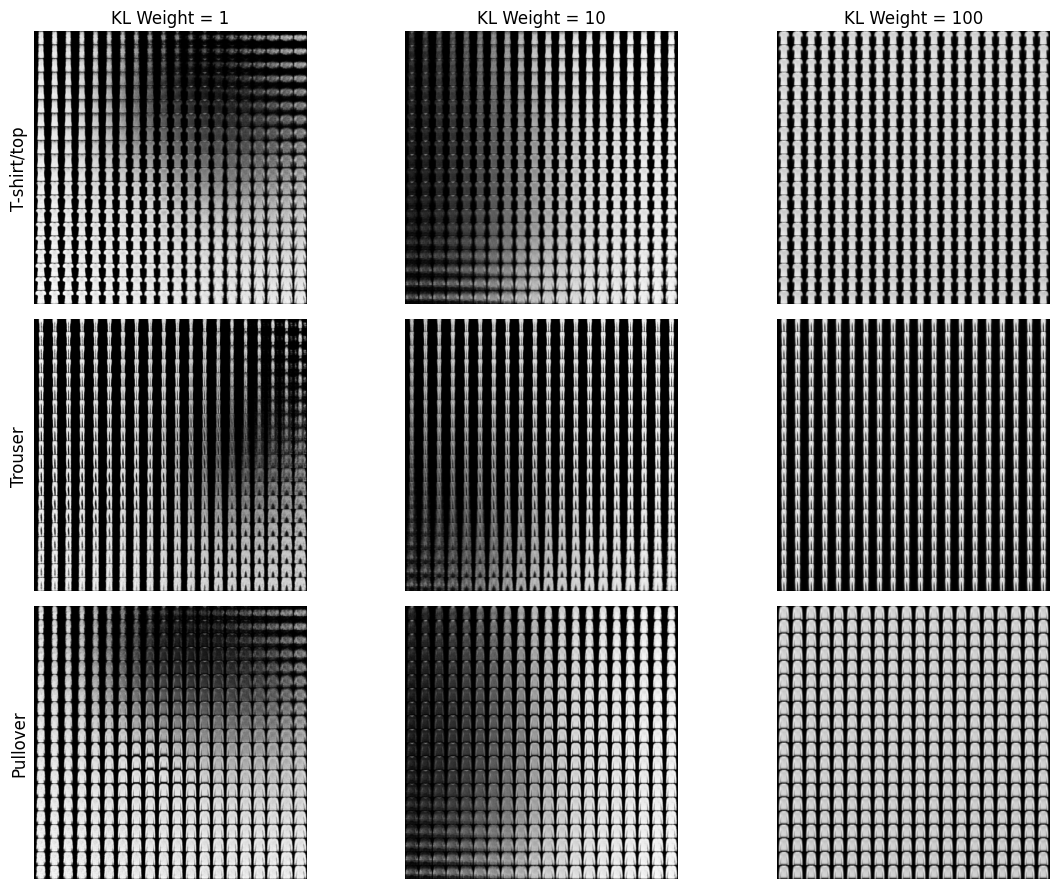

In [48]:
def plot_latent_manifolds_grid(models, betas, labels, device, grid_size=20, scale=3):

    n_labels = len(labels)
    fig, axes = plt.subplots(n_labels, len(models), figsize=(4*len(models), 3*n_labels))

    # Si 1 seul label → axes devient 1D, on force en 2D
    if n_labels == 1:
        axes = axes[np.newaxis, :]

    for row, label in enumerate(labels):
        for col, (model, beta) in enumerate(zip(models, betas)):
            
            model.eval()
            z1 = np.linspace(-scale, scale, grid_size)
            z2 = np.linspace(-scale, scale, grid_size)
            figure = np.zeros((28 * grid_size, 28 * grid_size))

            with torch.no_grad():
                for i, yi in enumerate(z1):
                    for j, xj in enumerate(z2):
                        z = torch.tensor([[yi, xj]], dtype=torch.float32).to(device)
                        y_tensor = torch.tensor([label], dtype=torch.long).to(device)
                        x_hat = model.decode(z, y_tensor)
                        img = x_hat.cpu().view(28, 28).numpy()
                        figure[i*28:(i+1)*28, j*28:(j+1)*28] = img
            
            ax = axes[row, col]
            ax.imshow(figure, cmap="gray")

            # 🔥 Enlever uniquement les graduations + frames
            ax.set_xticks([])
            ax.set_yticks([])
            ax.tick_params(axis='both', which='both', length=0)
            for spine in ax.spines.values():
                spine.set_visible(False)

            # Titres
            if row == 0:
                ax.set_title(f"KL Weight = {beta}", fontsize=12)

            if col == 0:
                ax.set_ylabel(classes[label], fontsize=12)

    plt.tight_layout()
    plt.show()


plot_latent_manifolds_grid(
    models=[CVAE_1, CVAE_10, CVAE_100],
    betas=[1, 10, 100],
    labels=[0,1,2],             # On choisit ici les habits qu'on veut afficher !
    device=device
)


On observe que plus la valeur de KL Weight est elevée, plus l'espace l'espace latent devient uniforme.
Quand on a KL Weight = 100, peut importe la valeur de (z1,z2) on aura la même sortie. Par contre on a beaucoup plus de diversité quand KL Weight est plus bas. Cela peut engendrer des génération incohérentes.

On voit aussi que le modèle mélange les Sandales et les Sneakers.

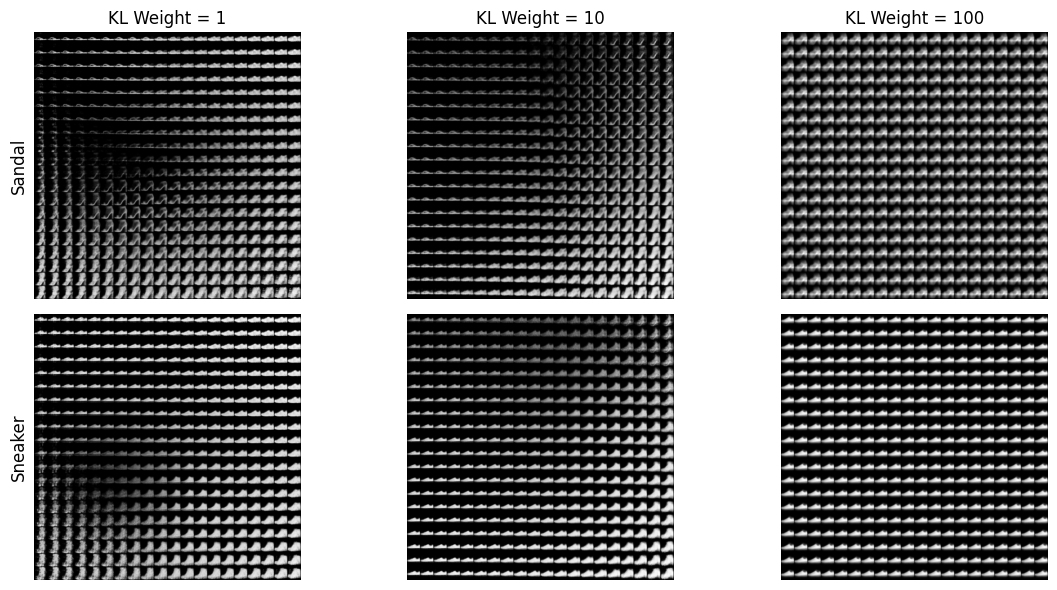

In [50]:
plot_latent_manifolds_grid(models=[CVAE_1, CVAE_10, CVAE_100],betas=[1, 10, 100],labels=[5,7],device=device)